In [1]:
import numpy as np
import matplotlib as mlp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import math
import time
%matplotlib notebook
np.random.seed(10)

In [2]:
# Create a random N^2 covarience matrix
covarience = np.cov(np.random.rand(2,3))

In [3]:
# create many samples from a bivariate Gaussian distribution, based on the covarience matrix
# this will be our data pool
samples = np.random.multivariate_normal([0,0], covarience, size = 250)

In [4]:
ang = math.pi / 6.0
a = math.tan(ang)

In [5]:
points = np.dot(samples, np.array([[np.cos(ang), np.sin(-ang)],[np.sin(ang), np.cos(ang)]]))

In [6]:
points = np.dot(samples, (1/(a**2 + 1)) * np.array([[1,a],[a,a**2]]))

<IPython.core.display.Javascript object>


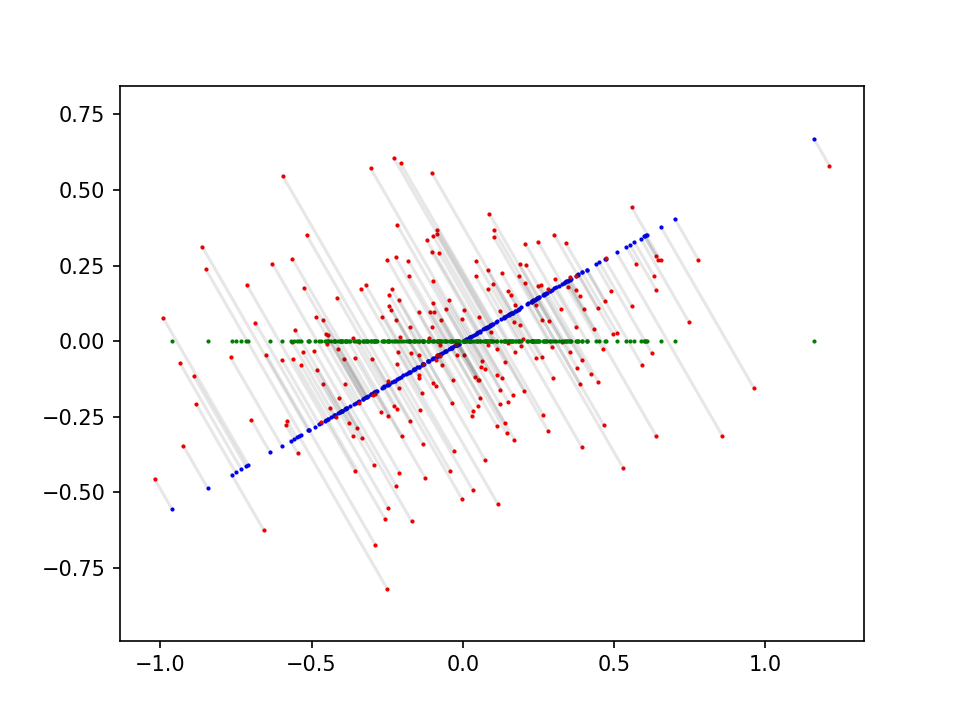

0.104029256676


(-1.1331834524303122,
 1.326616911753868,
 -0.89468998740726424,
 0.74695551650834502)

In [7]:
plt.close()
plt.plot(
    [np.transpose(points)[0],np.transpose(samples)[0]],
    [np.transpose(points)[1],np.transpose(samples)[1]],
    color = [0.1, 0.1, 0.1, 0.1],
    )
plt.scatter(np.transpose(points)[0], np.transpose(points)[1], s = 1, c = 'blue')
plt.scatter(np.transpose(samples)[0], np.transpose(samples)[1], s = 1, c = 'red')

# plt.scatter(np.transpose(points)[0]/(math.cos(ang)), 0*np.transpose(points)[1], s = 1, c = 'green')

plt.scatter(np.transpose(points)[0], 0*np.transpose(points)[1], s = 1, c = 'green')

# print(np.var(np.transpose(points)[0]/(math.cos(ang))))
print(np.var(np.transpose(points)[0]))

plt.axis("equal")


In [34]:
def get_var(angle, cov, n = 250):
    
#     print(angle)
#     print(cov)
#     print(n)
    
    samples = np.random.multivariate_normal([0,0], cov, size = int(n))
    
    a = np.tan(angle)
    
    if(type(angle) == type(np.array([]))):
        var = angle
        for i in range(len(angle)):
            var[i] = get_var(angle[i], cov, n)
        return var
    
    points = np.dot(samples, (1/(a**2 + 1)) * np.array([[1,a],[a,a**2]]))
    
    return np.var(np.transpose(points)[0]/(math.cos(angle)))

In [63]:
def get_var_sim(angle, cov, n = -1): # if 'n' is negative, should return the true variance
    
    angle *= -1
    
    var_xx = cov[0][0] * np.cos(angle)**2 + cov[1][1] * np.sin(angle)**2 - 2*np.cos(angle)*np.sin(angle)*cov[0][1] 
    
    if(n<0):
        return(var_xx)
    
#     std = var_xx**(0.5)
    
    return np.random.normal(loc = var_xx, scale = var_xx * np.sqrt(2/(n-1)))

We use the SPSA algorithm as defined by the iterative equation:

$
\sigma_{k+1} = \sigma_{k} + \alpha_{k}g_{k} 
$

where the gradient equation is definied as:

$$
g_{k} = \frac{f(\sigma_{k} + \beta_{k}\Delta_{k}) − f(\sigma_{k} - \beta_{k}\Delta_{k})}{2\beta_{k}}\Delta_{k}
$$

We control the convergence using these functions:

$$
\alpha_{k} = \frac{a}{(k + 1 + A)^S}
$$

$$
\beta_{k} = \frac{b}{(k + 1)^t}
$$

In [29]:
def spsa(x, delta, k, cov, s = 0.602, t = 0.101, a = 1e-1, b = 1e-1, A_ = 0):
    
    alpha_k = a/(k + 1 + A_)**s
    beta_k = b/(k + 1)**t

    return(x + alpha_k*gradient(x, k, beta_k, delta, cov))

In [104]:
def gradient(x, k, beta_k, delta_k, cov, N = 1e2):
    
#     small_samples = np.random.multivariate_normal([0,0], cov, size = N)
    
    f1 = get_var_sim(x + beta_k*delta_k, cov, N)
    f2 = get_var_sim(x - beta_k*delta_k, cov, N)
    
    return(((f2 - f1) / beta_k) * delta_k)

In [102]:
ang = 0

covarience = np.cov(np.random.rand(2,3))

# samples = np.random.multivariate_normal([0,0], covarience, size = 2500)

path = np.array([np.append(ang, get_var(ang, covarience, 2500))])

for i in range(10000):
        #delta = np.random.rand(1)*2 -1
        delta = np.random.normal()
        ang = spsa(ang, delta, i, covarience, a = 0.5)
        path = np.append(path, [np.append([ang], [get_var(ang, covarience)])], axis = 0)
print(ang)
print(get_var(ang,covarience, 2500))

0.892358864301
0.00310058242336


<IPython.core.display.Javascript object>


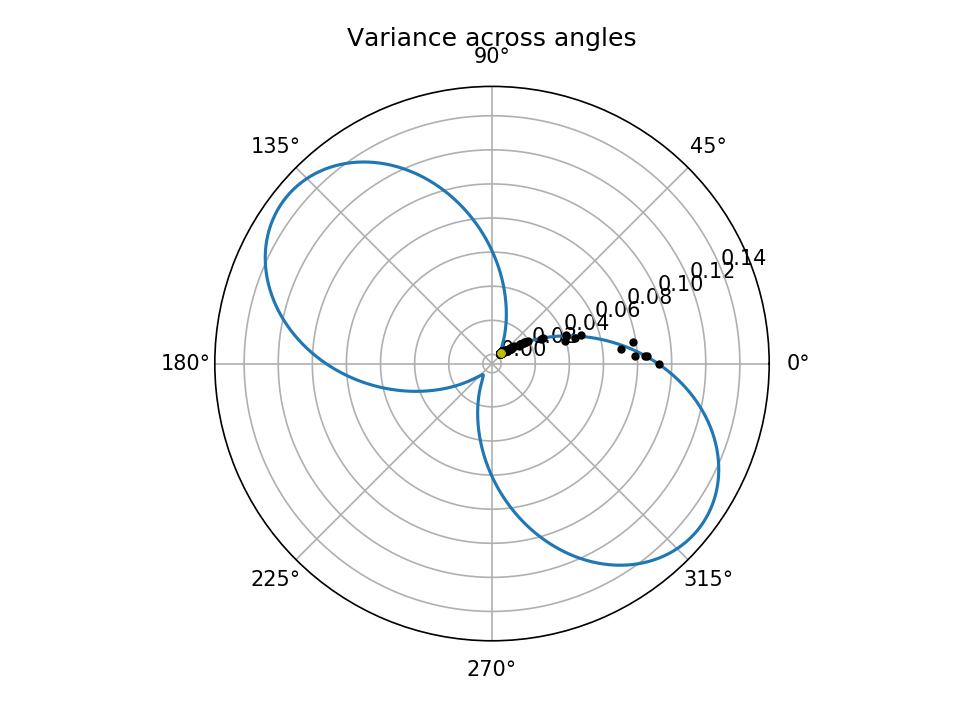

Text(0.5,1.05,'Variance across angles')

In [103]:
plt.close()
# plt.polar(np.arange(0, 2*math.pi, 0.01), get_var(np.arange(0, 2*math.pi, 0.01), covarience, 2500))
plt.polar(np.arange(0, 2*math.pi, 0.01), get_var_sim(np.arange(0, 2*math.pi, 0.01), covarience))
#print(path)
plt.polar(path[:,0], path[:,1], 'k.')

plt.polar(ang, get_var_sim(ang,covarience) ,'y.')


eig_val, eig_vec = np.linalg.eig(covarience)

min_vec = eig_vec[np.argmin(eig_val)]
min_ang = np.arctan2(min_vec[1], min_vec[0])
plt.polar(math.pi-min_ang, get_var_sim(math.pi-min_ang, covarience), 'y.')

plt.title("Variance across angles")

<IPython.core.display.Javascript object>


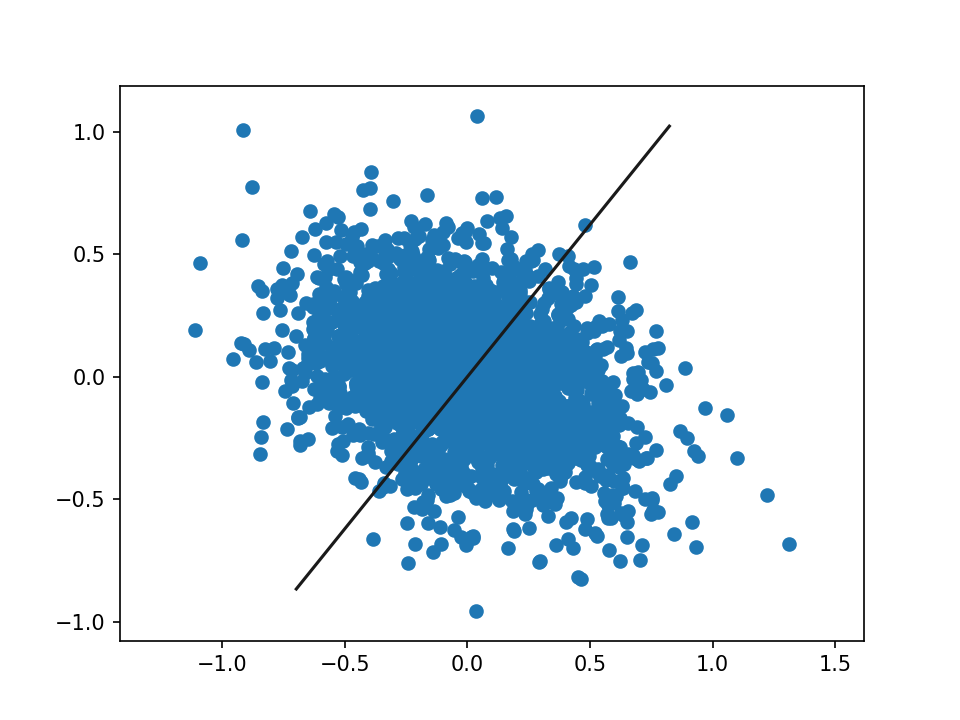

(-1.2443112524189492,
 1.4453497819116563,
 -1.0770394932398208,
 1.1844723217540996)

In [105]:
plt.close()

plt.plot(
    [np.cos(ang)*min(np.transpose(samples)[0]),np.cos(ang)*max(np.transpose(samples)[0])],
    [np.sin(ang)*min(np.transpose(samples)[0]), np.sin(ang)*max(np.transpose(samples)[0])],
    color = [0.1, 0.1, 0.1],
    )


#plt.scatter(np.transpose(points)[0], np.transpose(points)[1])
plt.scatter(np.transpose(samples)[0], np.transpose(samples)[1])
#plt.scatter(np.transpose(points)[0]/(math.cos(ang)), 0*np.transpose(points)[1])
plt.axis('equal')

<IPython.core.display.Javascript object>


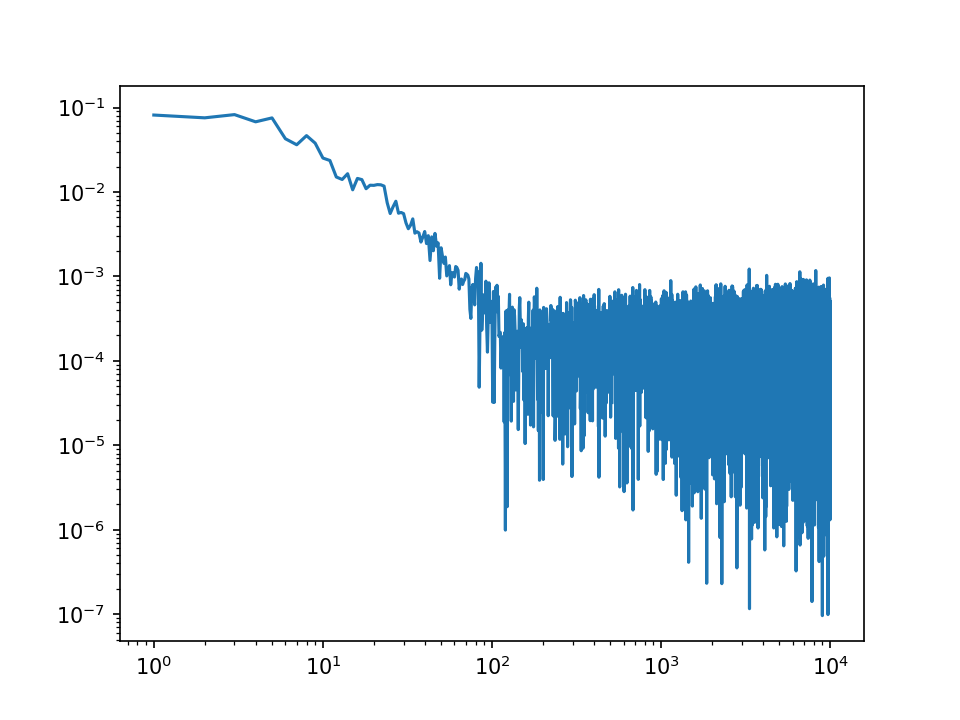

In [106]:
plt.close()


eig_val, eig_vec = np.linalg.eig(covarience)
min_vec = eig_vec[np.argmin(eig_val)]
min_ang = math.pi - np.arctan2(min_vec[1], min_vec[0])

#min_var_6 = min(get_var(np.linspace(0, 2*math.pi, num = 1e6), samples))
plt.loglog((abs(path[:,1] - get_var_sim(min_ang, covarience))))
#plt.loglog(abs(path[:,1] - min_var_6))

<IPython.core.display.Javascript object>


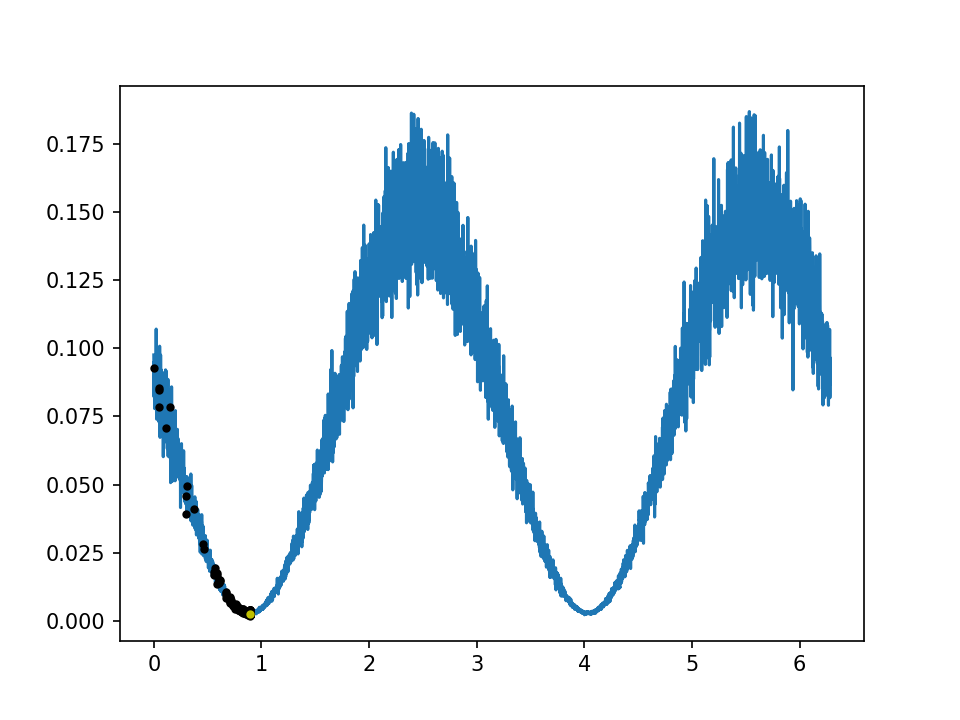

In [107]:
plt.close()

plt.plot(np.arange(0, 2*math.pi, 0.001), get_var(np.arange(0, 2*math.pi, 0.001), covarience))
plt.plot(path[:,0], path[:,1], 'k.')
plt.plot(path[:,0][-1], path[:,1][-1],'y.')

In [109]:
covarience = np.cov(np.random.rand(2,3))
samples = np.random.multivariate_normal([0,0], covarience, size = 250)

ang = 0.1 * math.pi
a = math.tan(ang)
np.dot([[1,0],[0,1]], (1/(a**2 + 1)) * np.array([[1,a],[a,a**2]]))

points = np.dot(samples, (1/(a**2 + 1)) * np.array([[1,a],[a,a**2]]))

<IPython.core.display.Javascript object>


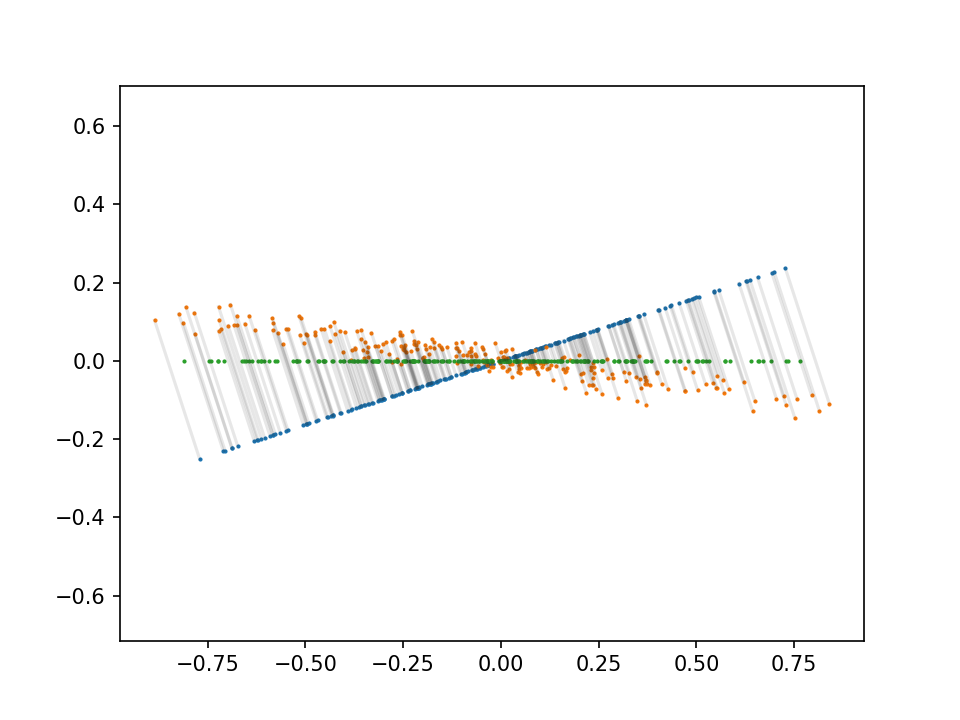

(-0.97396520654522178,
 0.92829465684075507,
 -0.27548887574355252,
 0.26145938856529866)

In [110]:
plt.close()
plt.plot(
    [np.transpose(points)[0],np.transpose(samples)[0]],
    [np.transpose(points)[1],np.transpose(samples)[1]],
    color = [0.1, 0.1, 0.1, 0.1],
    )
plt.scatter(np.transpose(points)[0], np.transpose(points)[1], s = 1)
plt.scatter(np.transpose(samples)[0], np.transpose(samples)[1], s = 1)
plt.scatter(np.transpose(points)[0]/(math.cos(ang)), 0*np.transpose(points)[1], s = 1)
plt.axis("equal")

-0.188333708816
0.0305797571057


<IPython.core.display.Javascript object>


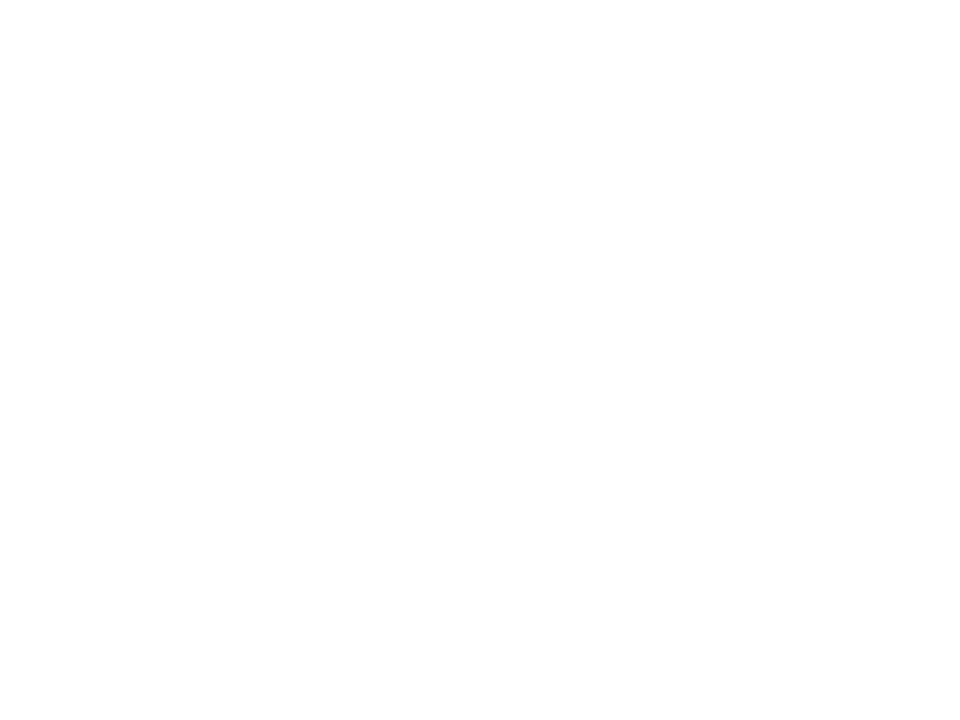

(-0.51026104821343887,
 0.55751244284581258,
 -1.1811337639732189,
 1.4226644577264858)

In [580]:
ang = 0

#samples = np.random.multivariate_normal([0,0], covarience, size = 2500)

path = np.array([np.append(ang, get_var(ang, samples))])

for i in range(5000):
        #delta = np.random.rand(1)*2 -1
        delta = np.random.normal()
        ang = spsa(ang, delta, i)
        path = np.append(path, [np.append([ang], [get_var(ang,samples)])], axis = 0)
print(ang)
print(get_var(ang,samples))


plt.close()
plt.scatter(np.transpose(samples)[0], np.transpose(samples)[1], s = 1)
plt.axis('equal')

<IPython.core.display.Javascript object>


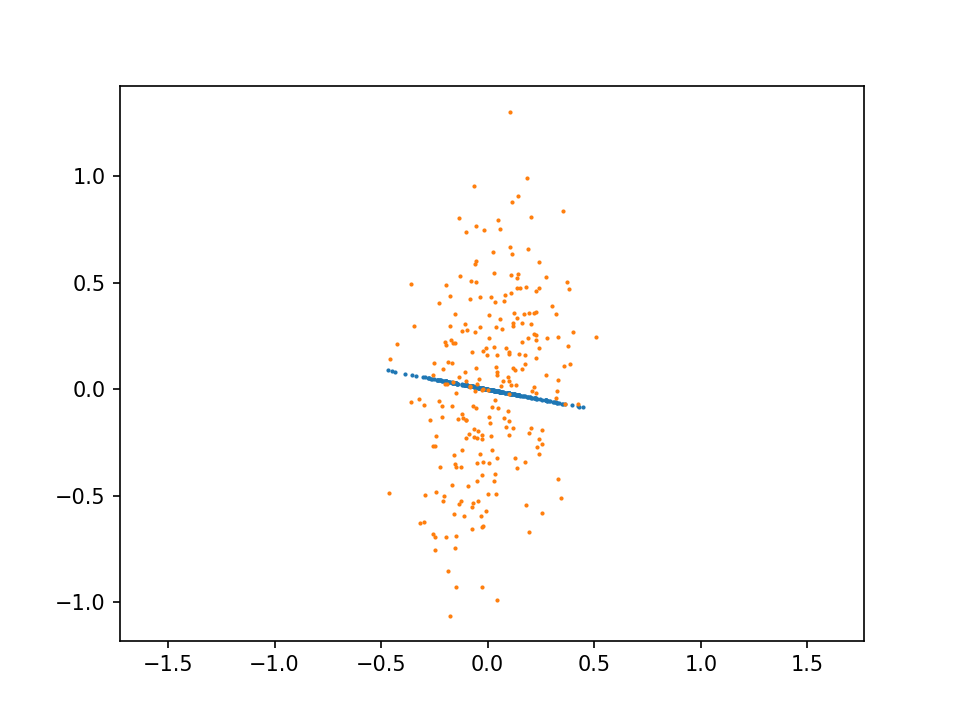

(-0.5170510086643969,
 0.55784207958794263,
 -1.1799347817002452,
 1.4214654754535121)

In [584]:
a = math.tan(ang)
np.dot([[1,0],[0,1]], (1/(a**2 + 1)) * np.array([[1,a],[a,a**2]]))

points = np.dot(samples, (1/(a**2 + 1)) * np.array([[1,a],[a,a**2]]))

plt.close()
'''plt.plot(
    [np.transpose(points)[0],np.transpose(samples)[0]],
    [np.transpose(points)[1],np.transpose(samples)[1]],
    color = [0.1, 0.1, 0.1, 0.1],
    )'''
plt.scatter(np.transpose(points)[0], np.transpose(points)[1], s = 1)
plt.scatter(np.transpose(samples)[0], np.transpose(samples)[1], s = 1)
#plt.scatter(np.transpose(points)[0]/(math.cos(ang)), 0*np.transpose(points)[1], s = 1)
plt.axis("equal")